In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from random import random
import time
import warnings
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_predict

# Acquiring Data

### Sleep Data

In [2]:
sleep_df = pd.read_csv ('.\Data\SLEEP_1658994387914.csv', sep=',', header=0)
sleep_df.rename(columns = {'deepSleepTime':'deepSleepTime [m]', 'shallowSleepTime':'shallowSleepTime[m]', 'wakeTime':'wakeTime[m]'}, inplace = True)

In [3]:
sleep_df

,date,deepSleepTime [m],shallowSleepTime[m],wakeTime[m],start,stop
2022-06-12,1655122788,0,0,0,1654898400,1654898400
2022-06-13,1655158791,133,322,3,1655073720,1655101200
2022-06-14,1655247034,68,179,0,1655165520,1655180340
2022-06-15,1655333446,0,0,0,1655157600,1655157600
2022-06-16,1655418046,183,308,2,1655333580,1655363160
2022-06-17,1655506236,192,237,0,1655417460,1655443200
2022-06-18,1655592673,135,361,0,1655506080,1655535840
2022-06-19,1655679048,210,262,0,1655590140,1655618460


Changing times from [m] to [h]

In [4]:
sleep_df.rename(columns = {'deepSleepTime [m]':'deepSleepTime [h]', 'shallowSleepTime[m]':'shallowSleepTime[h]', 'wakeTime[m]':'wakeTime[h]'}, inplace = True)
sleep_df.loc[:,"deepSleepTime [h]"] = np.round(sleep_df.loc[:,"deepSleepTime [h]"]/60,2)
sleep_df.loc[:,"shallowSleepTime[h]"] = np.round(sleep_df.loc[:,"shallowSleepTime[h]"]/60,2)
sleep_df.loc[:,"wakeTime[h]"] = np.round(sleep_df.loc[:,"wakeTime[h]"]/60,2)
sleep_df['date'] = (pd.to_datetime(sleep_df['date'], unit='s')
                     .dt.tz_localize('utc')
                     .dt.tz_convert('Europe/Rome'))    
sleep_df['start'] = (pd.to_datetime(sleep_df['start'], unit='s')
                     .dt.tz_localize('utc')
                     .dt.tz_convert('Europe/Rome')) 
sleep_df['stop'] = (pd.to_datetime(sleep_df['stop'], unit='s')
                     .dt.tz_localize('utc')
                     .dt.tz_convert('Europe/Rome')) 

In [5]:
# summing cumulative sleep time
new_col = sleep_df['deepSleepTime [h]'] + sleep_df['shallowSleepTime[h]']
sleep_df.insert(4, 'totalSleepTime[h]', new_col)

In [6]:
sleep_df

,date,deepSleepTime [h],shallowSleepTime[h],wakeTime[h],totalSleepTime[h],start,stop
2022-06-12,2022-06-13 14:19:48+02:00,0.00,0.00,0.00,0.00,2022-06-11 00:00:00+02:00,2022-06-11 00:00:00+02:00
2022-06-13,2022-06-14 00:19:51+02:00,2.22,5.37,0.05,7.59,2022-06-13 00:42:00+02:00,2022-06-13 08:20:00+02:00
2022-06-14,2022-06-15 00:50:34+02:00,1.13,2.98,0.00,4.11,2022-06-14 02:12:00+02:00,2022-06-14 06:19:00+02:00
2022-06-15,2022-06-16 00:50:46+02:00,0.00,0.00,0.00,0.00,2022-06-14 00:00:00+02:00,2022-06-14 00:00:00+02:00
2022-06-16,2022-06-17 00:20:46+02:00,3.05,5.13,0.03,8.18,2022-06-16 00:53:00+02:00,2022-06-16 09:06:00+02:00
2022-06-17,2022-06-18 00:50:36+02:00,3.20,3.95,0.00,7.15,2022-06-17 00:11:00+02:00,2022-06-17 07:20:00+02:00
2022-06-18,2022-06-19 00:51:13+02:00,2.25,6.02,0.00,8.27,2022-06-18 00:48:00+02:00,2022-06-18 09:04:00+02:00
2022-06-19,2022-06-20 00:50:48+02:00,3.50,4.37,0.00,7.87,2022-06-19 00:09:00+02:00,2022-06-19 08:01:00+02:00


In [7]:
deep_sleep = sleep_df.loc[:,"deepSleepTime [h]"].tolist()
shallow_sleep = sleep_df.loc[:,"shallowSleepTime[h]"].tolist()
wake_sleep = sleep_df.loc[:,"wakeTime[h]"].tolist()
labels = sleep_df.index.tolist()

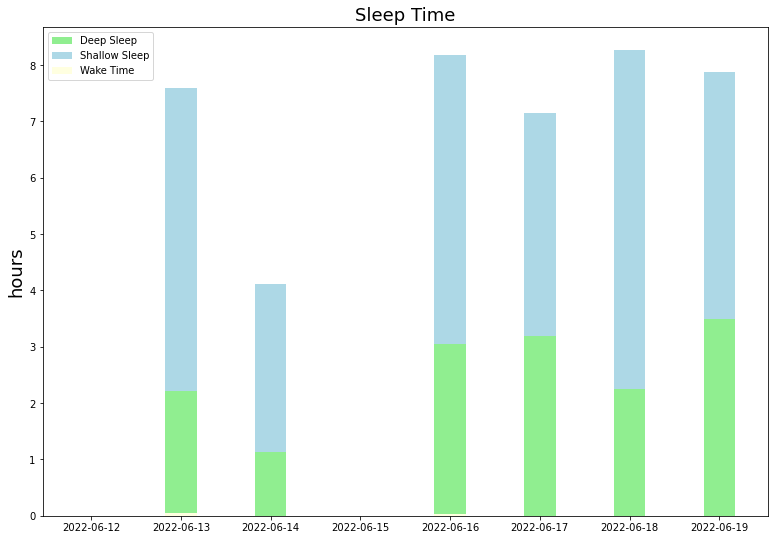

In [8]:
width = 0.35 

fig, ax = plt.subplots(figsize=(13, 9))

ax.bar(labels, deep_sleep, width, label='Deep Sleep', color='lightgreen')
ax.bar(labels, shallow_sleep, width,  bottom=deep_sleep, label='Shallow Sleep', color='lightblue')
ax.bar(labels, wake_sleep, width, label='Wake Time', color='lightyellow')

ax.set_ylabel('hours', size=18)
ax.set_title('Sleep Time', size=18)
ax.legend()

plt.show()

# Sport activities Data

In [9]:
sport_df = pd.read_csv ('.\Data\SPORT_1658994387972.csv', sep=',', header=0)

In [10]:
sport_df

,type,startTime,sportTime(s),maxPace(/meter),minPace(/meter),distance(m),avgPace(/meter),calories(kcal)
0,16,2022-06-17 19:06:26+0000,6671,0.0,1.8,0.0,0.0,573.0
1,16,2022-06-17 18:58:07+0000,313,0.0,1.8,0.0,0.0,43.0
2,16,2022-06-17 18:40:18+0000,829,0.0,1.8,0.0,0.0,144.0
3,16,2022-06-16 16:21:55+0000,6118,0.0,1.8,0.0,0.0,604.0
4,16,2022-06-15 17:09:11+0000,5160,0.0,1.8,0.0,0.0,644.0
5,16,2022-06-13 16:51:31+0000,7888,0.0,1.8,0.0,0.0,934.0


In [11]:
sport_df = sport_df.drop(columns=['maxPace(/meter)', 'minPace(/meter)','distance(m)', 'avgPace(/meter)'])
# changing time from [s] to [m]
sport_df.loc[:,"sportTime(s)"] = np.round(sport_df.loc[:,"sportTime(s)"]/60,1)
sport_df.rename(columns = {'sportTime(s)':'sportTime(m)'}, inplace = True)

In [12]:
sport_df

,type,startTime,sportTime(m),calories(kcal)
0,16,2022-06-17 19:06:26+0000,111.2,573.0
1,16,2022-06-17 18:58:07+0000,5.2,43.0
2,16,2022-06-17 18:40:18+0000,13.8,144.0
3,16,2022-06-16 16:21:55+0000,102.0,604.0
4,16,2022-06-15 17:09:11+0000,86.0,644.0
5,16,2022-06-13 16:51:31+0000,131.5,934.0


In [13]:
sport_df['date'] = sport_df['startTime'].str.slice(0,10)

In [14]:
#sport_df.loc[sport_df['TYPE']!='OFFSET','I_VAL']=df.groupby(['DATE','A_ID','R_ID'],as_index=False,sort=False).transform('sum')[df['TYPE']!='OFFSET']['I_VAL']


# HEARTRATE

HeartRate series from 12 of June to 19 of June

In [181]:
heartrate_df = pd.read_csv ('.\Data\HEARTRATE_AUTO_1658994387948.csv', sep=',', header=0)

In [182]:
heartrate_df

,date,time,heartRate
0,2022-06-12,09:25,68
1,2022-06-12,09:28,68
2,2022-06-12,09:35,80
3,2022-06-12,09:45,70
4,2022-06-12,09:55,64
...,...,...,...
2312,2022-06-19,23:16,80
2313,2022-06-19,23:26,61
2314,2022-06-19,23:36,70
2315,2022-06-19,23:46,70


In [183]:
heartrate_df['date'] = pd.to_datetime(heartrate_df['date'],infer_datetime_format=True) #convert from string to datetime
heartrate_df['time'] = pd.to_datetime(heartrate_df['time'], format='%H:%M').dt.strftime("%H:%M")

In [184]:
heartrate_df

,date,time,heartRate
0,2022-06-12,09:25,68
1,2022-06-12,09:28,68
2,2022-06-12,09:35,80
3,2022-06-12,09:45,70
4,2022-06-12,09:55,64
...,...,...,...
2312,2022-06-19,23:16,80
2313,2022-06-19,23:26,61
2314,2022-06-19,23:36,70
2315,2022-06-19,23:46,70


In [185]:
heartrate_df['date'] = pd.to_datetime(heartrate_df['date'].astype(str)+' '+heartrate_df['time'].astype(str), format='%Y-%m-%d %H:%M')
heartrate_df['date'] = heartrate_df['date'].dt.strftime('%Y-%m-%d %H:%M')
heartrate_df = heartrate_df.drop(columns=['time'])

# generating the indexed dataset
indexed_dataset = heartrate_df.set_index(['date'])

In [192]:
starting_date = datetime.strptime(heartrate_df['date'].iloc[0], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")
end_date = datetime.strptime(heartrate_df['date'].iloc[-1], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")

In [193]:
print('Start date: {}\nEnd date: {}'.format(starting_date, end_date))

Start date: 2022-06-12
End date: 2022-06-19


In [194]:
dates = heartrate_df.loc[:,"date"].tolist()
heartrates = heartrate_df.loc[:,"heartRate"].tolist()

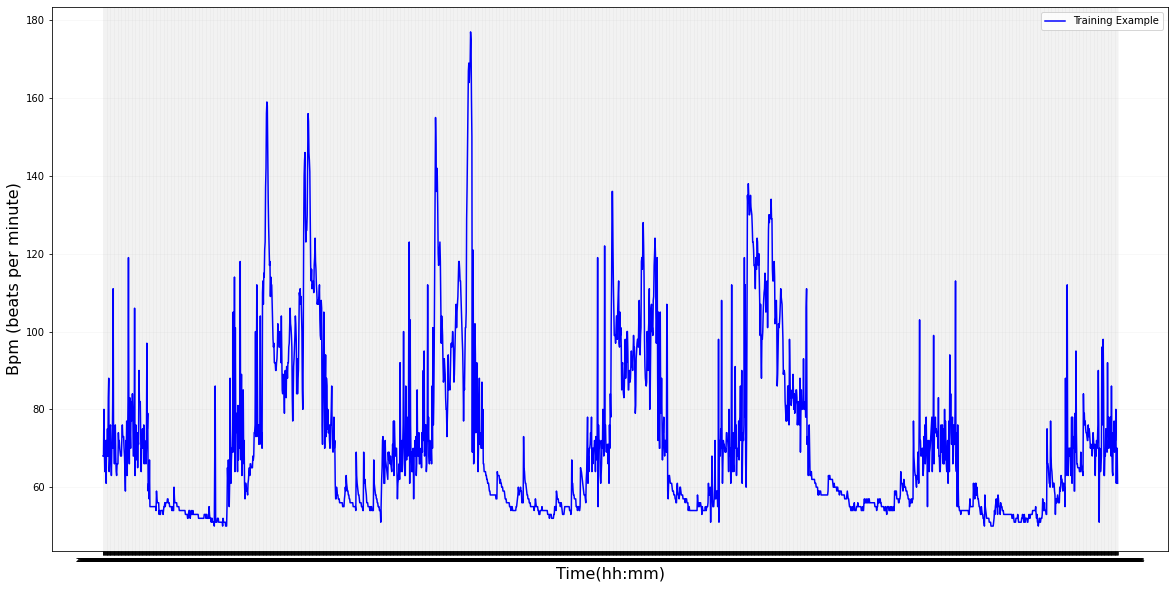

In [195]:
plt.figure(figsize = (20,10)) # declaire environment to draw
# (12,5) = (columns,rows)
plt.plot(indexed_dataset, c='blue', label='Training Example')
plt.xlabel("Time(hh:mm)", fontsize=16)
plt.ylabel("Bpm (beats per minute)", fontsize=16)
plt.tick_params(axis='x', labelsize=6)
plt.tick_params(axis='y', labelsize=10)
plt.grid(alpha=0.1)
plt.legend()
plt.show()

# Trying to predict the last day

Source: https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima

In [209]:
X = heartrate_df[['date']]
Y = heartrate_df[['heartRate']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/7, shuffle=False)
train_dataset = pd.concat([X_train,y_train],axis=1)

indexed_train = train_dataset.set_index(['date'])

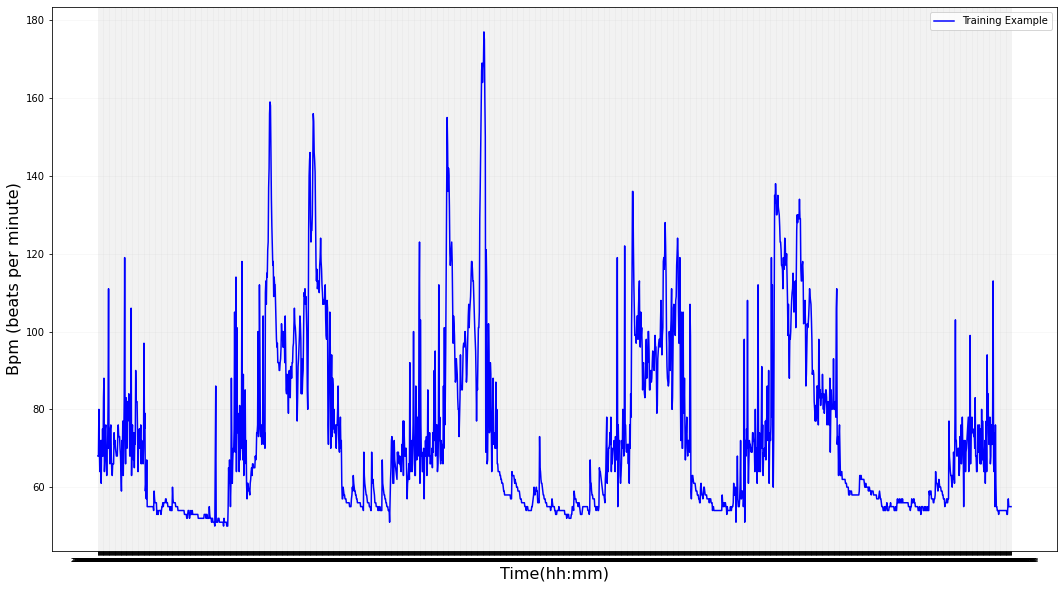

In [210]:
plt.figure(figsize = (18,10)) # declaire environment to draw
# (12,5) = (columns,rows)
plt.plot(indexed_train, c='blue', label='Training Example')
plt.xlabel("Time(hh:mm)", fontsize=16)
plt.ylabel("Bpm (beats per minute)", fontsize=16)
plt.tick_params(axis='x', labelsize=6)
plt.tick_params(axis='y', labelsize=10)
plt.grid(alpha=0.1)
plt.legend()
plt.show()

In [212]:
indexed_train.head(10)

,heartRate
date,
2022-06-12 09:25,68
2022-06-12 09:28,68
2022-06-12 09:35,80
2022-06-12 09:45,70
2022-06-12 09:55,64
2022-06-12 10:05,68
2022-06-12 10:15,72
2022-06-12 10:25,61
2022-06-12 10:35,72


In [215]:
#Determine rolling statistics
rolmean = train_dataset.rolling(window=12).mean() #window size 6 denotes 6 measures of 10 minutes, giving rolling mean at yearly hour
rolstd = train_dataset.rolling(window=12).std()

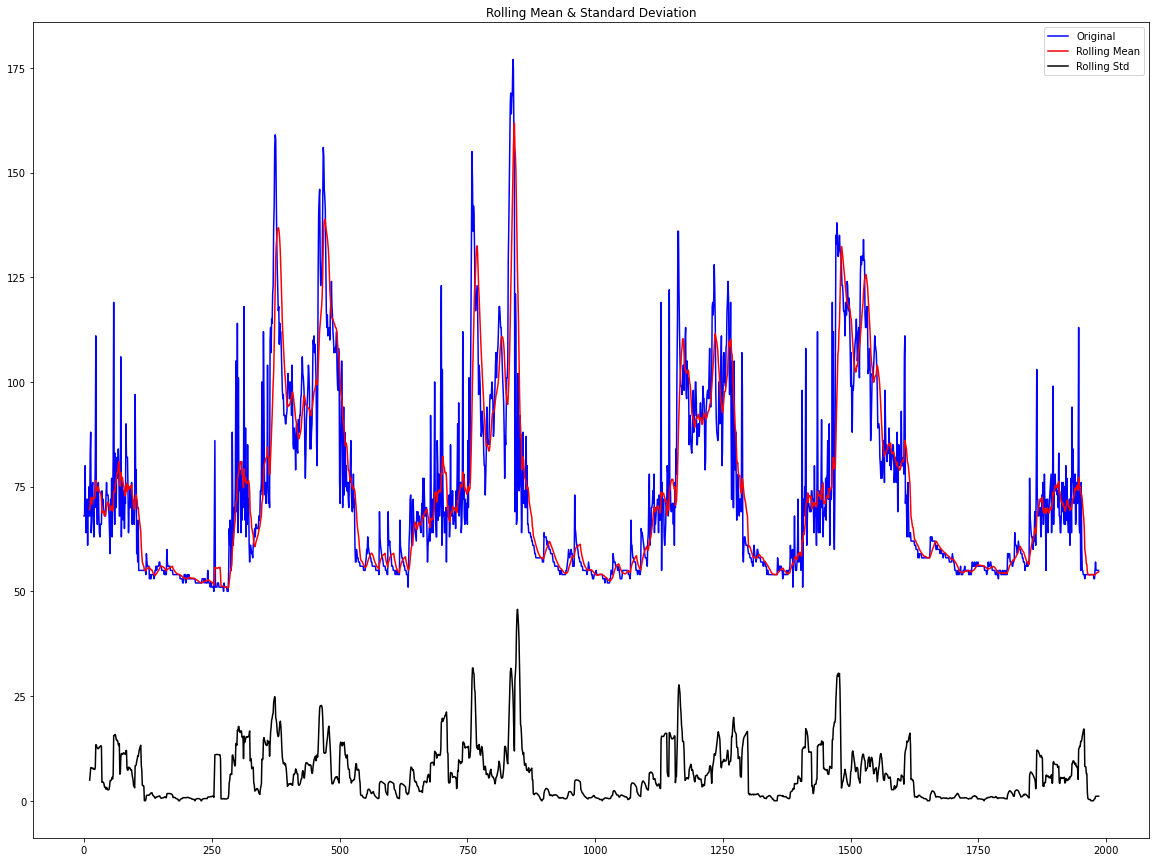

In [216]:
#Plot rolling statistics
plt.figure(figsize=(20,15))
orig = plt.plot(train_dataset['heartRate'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.

In [217]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexed_dataset['heartRate'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.848633
p-value                           0.002447
#Lags Used                       23.000000
Number of Observations Used    2293.000000
Critical Value (1%)              -3.433205
Critical Value (5%)              -2.862801
Critical Value (10%)             -2.567441
dtype: float64


For a Time series to be stationary, its ADCF test should have:

<ol>
    <li> p-value to be low (according to the null hypothesis) </li>
    <li> The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics </li>
</ol>
From the above ADCF test result, we see that p-value(at max can be 0.05) is very small. Otherwise critical values are no where close to the Test Statistics. In this particular example Time Series can be considered stationary, but the example on the notebook in the source is not, so procede with a solution to the non-stationatity problem (transformations)

# Data Transformation to achieve Stationarity 


There are a couple of ways to achieve stationarity through data transformation like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

## Log Scale Transformation 

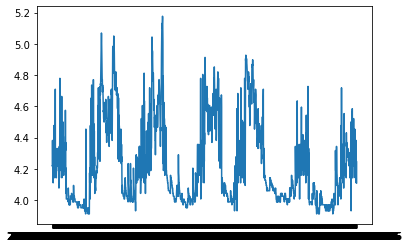

In [218]:
#Estimating trend
indexed_dataset_log_scale = np.log(indexed_dataset)
plt.plot(indexed_dataset_log_scale)
plt.show()

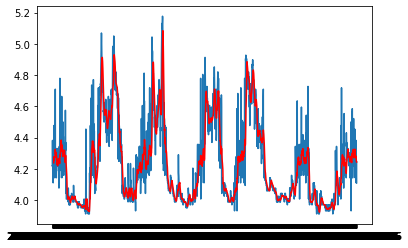

In [219]:
#The below transformation is required to make series stationary
moving_average = indexed_dataset_log_scale.rolling(window=12).mean()
moving_STD = indexed_dataset_log_scale.rolling(window=12).std()
plt.plot(indexed_dataset_log_scale)
plt.plot(moving_average, color='red')
plt.show()

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

<p> logscaleL=stationarypart(L1)+trend(LT) </p>
<p>movingavgoflogscaleA=stationarypart(A1)+trend(AT) </p>
<p>resultseriesR=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT) </p>
Since, L & A are series & it moving avg, their trend will be more or less same, Hence
LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

R=L1−A1 , our final non-trend curve

In [223]:
dataset_log_scale_minus_moving_average = indexed_dataset_log_scale - moving_average

#Remove NAN values
dataset_log_scale_minus_moving_average.dropna(inplace=True)
dataset_log_scale_minus_moving_average.head(10)

,heartRate
date,
2022-06-12 11:05,-0.019545
2022-06-12 11:15,0.163176
2022-06-12 11:25,0.200187
2022-06-12 11:35,-0.099672
2022-06-12 11:45,-0.050212
2022-06-12 11:55,0.049367
2022-06-12 12:05,0.053343
2022-06-12 12:15,-0.039737
2022-06-12 12:25,-0.133397


In [224]:
def test_stationarity(timeseries, window_size=12):
    
    #Determine rolling statistics
    moving_average = timeseries.rolling(window_size).mean()
    moving_STD = timeseries.rolling(window_size).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(16,12))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(moving_average, color='red', label='Rolling Mean')
    std = plt.plot(moving_STD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['heartRate'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

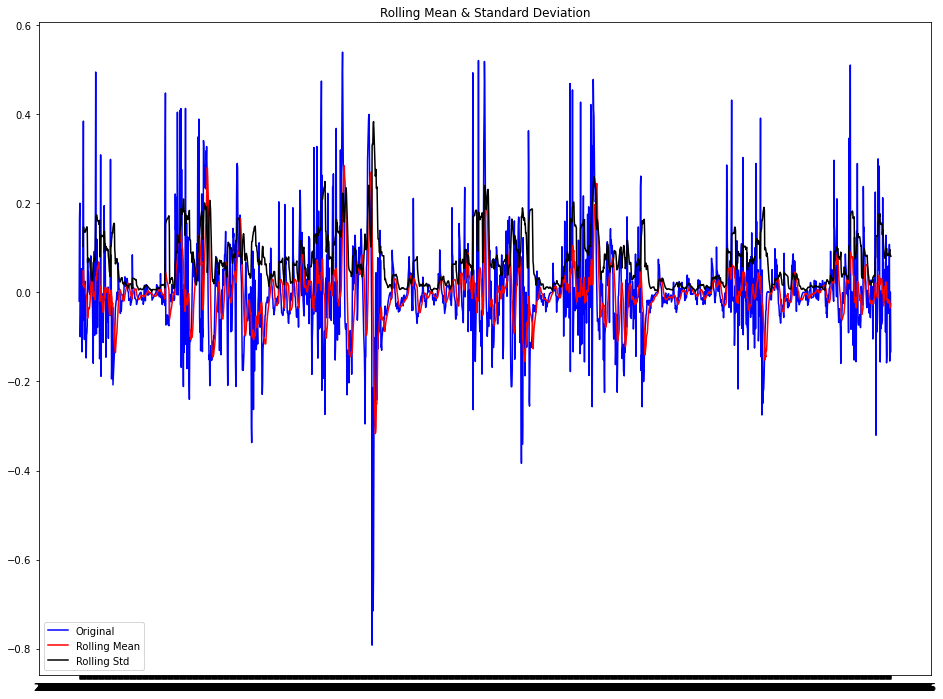

Results of Dickey Fuller Test:
Test Statistic                -1.016612e+01
p-value                        7.291597e-18
#Lags Used                     2.300000e+01
Number of Observations Used    2.282000e+03
Critical Value (1%)           -3.433219e+00
Critical Value (5%)           -2.862807e+00
Critical Value (10%)          -2.567445e+00
dtype: float64


In [225]:
test_stationarity(dataset_log_scale_minus_moving_average)


From above graph, we observe that our intuition that "subtracting two related series having similar trend components will make the result stationary" is true. We find that:

<ol>
    <li>p-value has reduced from 0.05 to 2*10^-17.</li>
    <li>The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus, from above 2 points, we can say that our given series is stationary.</li>
</ol> 
But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.
For further info, refer to my answer 12 at the top of the notebook on it.

## Exponential Decay Transformation


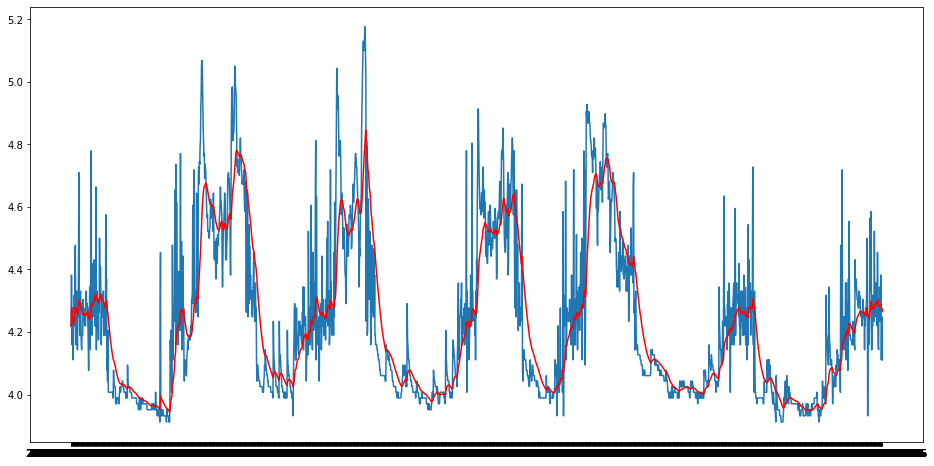

In [226]:
exponential_decay_weighted_average = indexed_dataset_log_scale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.figure(figsize=(16,8))
plt.plot(indexed_dataset_log_scale)
plt.plot(exponential_decay_weighted_average, color='red')
plt.show()

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.

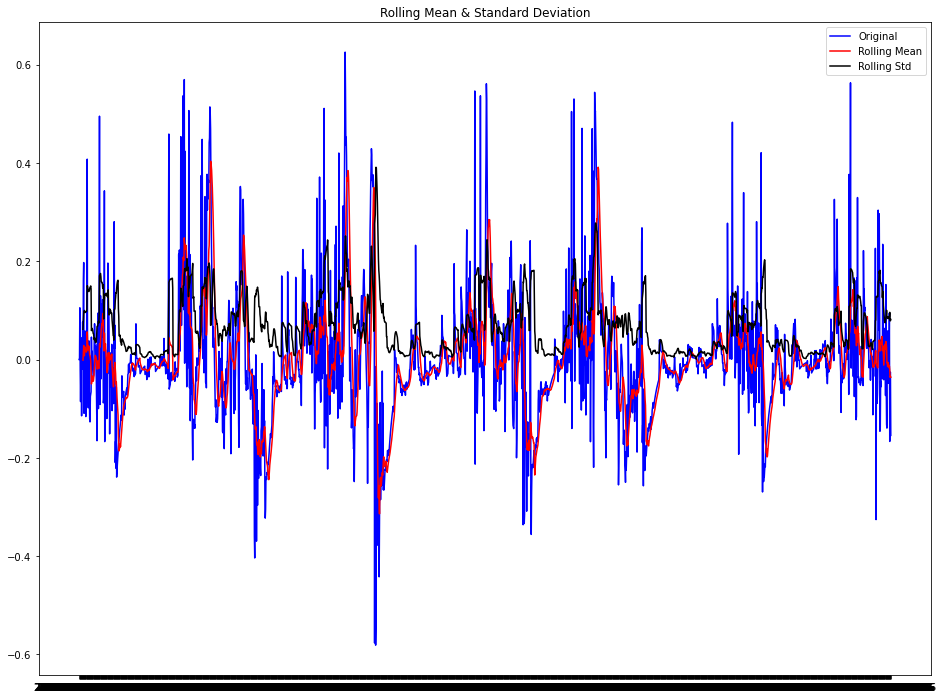

Results of Dickey Fuller Test:
Test Statistic                -7.067778e+00
p-value                        5.028218e-10
#Lags Used                     2.300000e+01
Number of Observations Used    2.293000e+03
Critical Value (1%)           -3.433205e+00
Critical Value (5%)           -2.862801e+00
Critical Value (10%)          -2.567441e+00
dtype: float64


In [227]:
dataset_log_scale_minus_exponential_moving_average = indexed_dataset_log_scale - exponential_decay_weighted_average
test_stationarity(dataset_log_scale_minus_exponential_moving_average)

# Time Shift Transformation

But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

Given a set of observation on the time series:
x0,x1,x2,x3,....xn <br>
The shifted values will be:<br>
null,x0,x1,x2,....xn  <---- basically all xi's shifted by 1 pos to right

Thus, the time series with time shifted values are:
null,(x1−x0),(x2−x1),(x3−x2),(x4−x3),....(xn−xn−1)

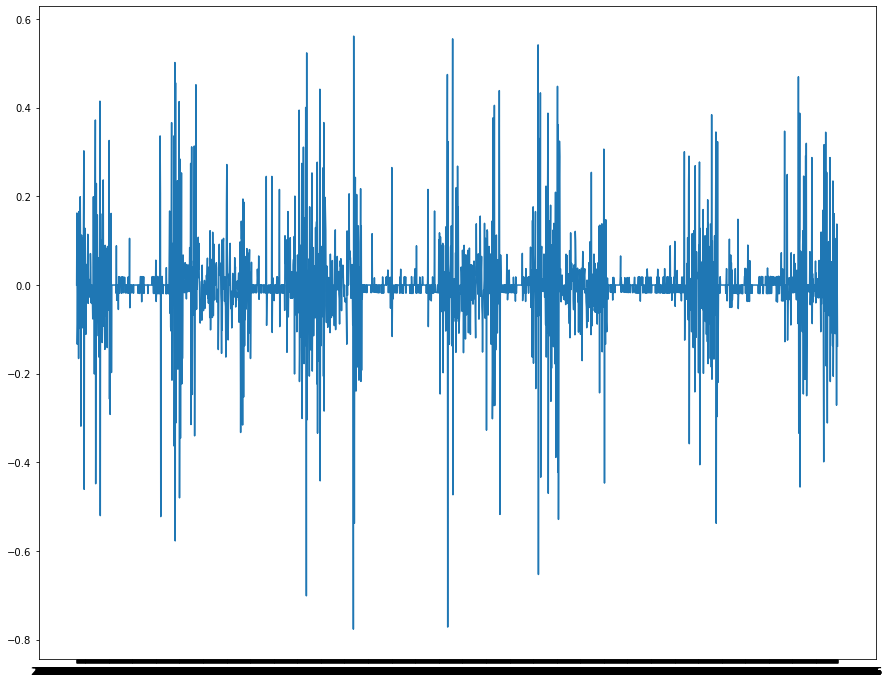

In [228]:
dataset_log_diff_shifting = indexed_dataset_log_scale - indexed_dataset_log_scale.shift()
plt.figure(figsize=(15,12))
plt.plot(dataset_log_diff_shifting)
plt.show()

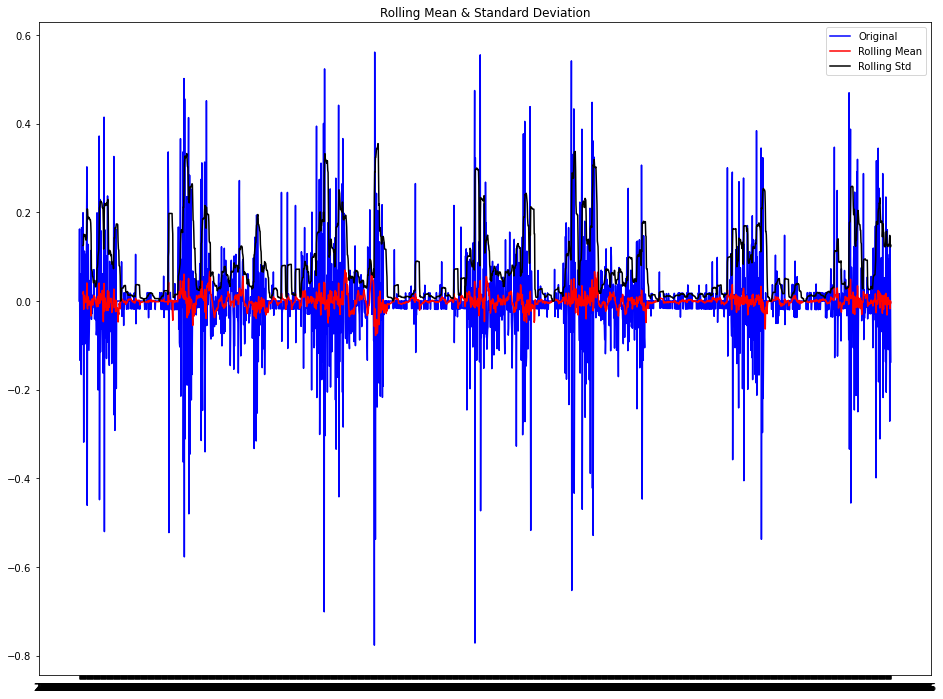

Results of Dickey Fuller Test:
Test Statistic                -1.170849e+01
p-value                        1.508747e-21
#Lags Used                     2.200000e+01
Number of Observations Used    2.293000e+03
Critical Value (1%)           -3.433205e+00
Critical Value (5%)           -2.862801e+00
Critical Value (10%)          -2.567441e+00
dtype: float64


In [229]:
dataset_log_diff_shifting.dropna(inplace=True)
test_stationarity(dataset_log_diff_shifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

<ol>
    <li>p-value of 0.07 is not as good as 0.005 of exponential decay. </li>
    <li>Test Statistic value not as close to the critical values as that for exponential decay.</li>
    </ol>
We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

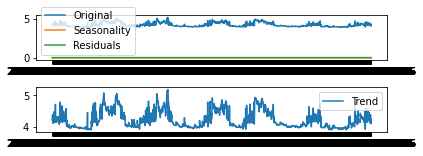

In [231]:
decomposition = seasonal_decompose(indexed_dataset_log_scale, model='additive', period=1) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexed_dataset_log_scale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.

In [234]:
residual

date
2022-06-12 09:25    0.0
2022-06-12 09:28    0.0
2022-06-12 09:35    0.0
2022-06-12 09:45    0.0
2022-06-12 09:55    0.0
                   ... 
2022-06-19 23:16    0.0
2022-06-19 23:26    0.0
2022-06-19 23:36    0.0
2022-06-19 23:46    0.0
2022-06-19 23:56    0.0
Name: resid, Length: 2317, dtype: float64

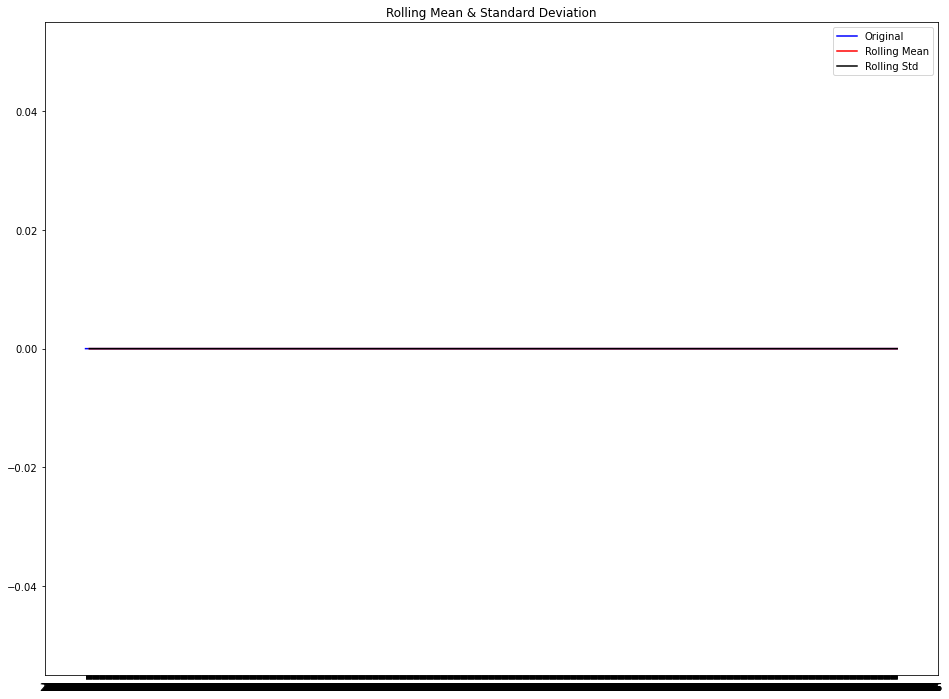

Results of Dickey Fuller Test:


KeyError: 'heartRate'

In [235]:
decomposed_log_data = residual
decomposed_log_data.dropna(inplace=True)
test_stationarity(decomposed_log_data)

# Plotting ACF & PACF

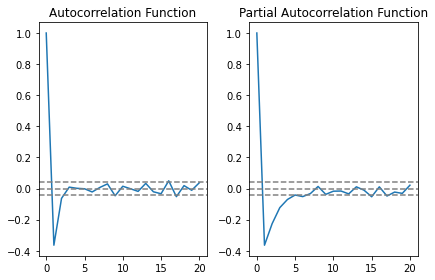

In [236]:
#ACF & PACF plots

lag_acf = acf(dataset_log_diff_shifting, nlags=20)
lag_pacf = pacf(dataset_log_diff_shifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_diff_shifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()     

From the ACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, Q = 1<br>
From the PACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, P = 1

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

# Building Models 
Fits ARIMA(p,d,q) model by exact maximum likelihood via Kalman filter

## AR Model

Plotting AR model


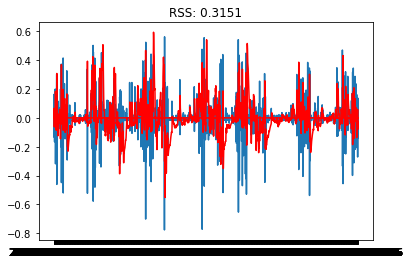

In [253]:
#making order=(1,1,0) gives RSS=1.5023
warnings.filterwarnings("ignore")
model = ARIMA(dataset_log_scale_minus_exponential_moving_average, order=(1,1,0))
results_AR = model.fit()
plt.plot(dataset_log_diff_shifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%(sum(results_AR.fittedvalues)  - sum(dataset_log_diff_shifting['heartRate'])**2))
print('Plotting AR model')

## MA Model

Plotting MA model


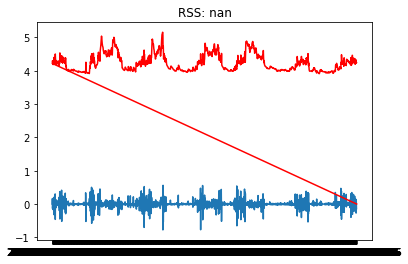

In [256]:
#MA Model
model = ARIMA(indexed_dataset_log_scale, order=(0,1,1))
results_MA = model.fit()
plt.plot(dataset_log_diff_shifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - dataset_log_diff_shifting['heartRate'])**2))
print('Plotting MA model')

## ARIMA Model

Plotting ARIMA model


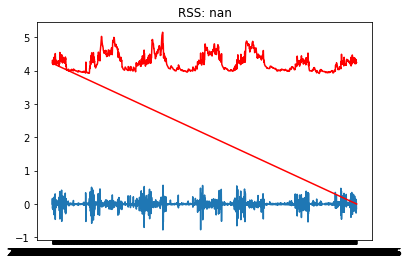

In [257]:
# AR+I+MA = ARIMA model
model = ARIMA(indexed_dataset_log_scale, order=(1,1,1))
results_ARIMA = model.fit()
plt.plot(dataset_log_diff_shifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - dataset_log_diff_shifting['heartRate'])**2))
print('Plotting ARIMA model')

# Continuing with Log Scale Transformation

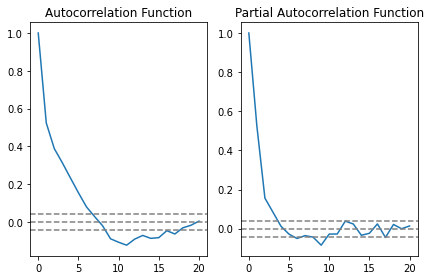

In [324]:
#ACF & PACF plots

lag_acf = acf(dataset_log_scale_minus_moving_average, nlags=20)
lag_pacf = pacf(dataset_log_scale_minus_moving_average, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_scale_minus_moving_average)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_scale_minus_moving_average)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dataset_log_scale_minus_moving_average)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataset_log_scale_minus_moving_average)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()  

# Building Models 

## AR MODEL

Plotting AR model


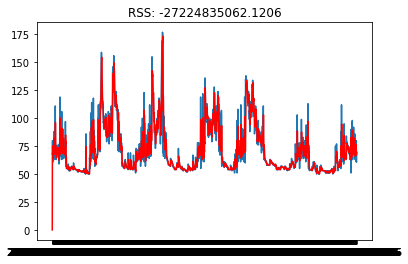

In [412]:
#making order=(8,1,0) 
warnings.filterwarnings("ignore")
model = ARIMA(indexed_dataset, order=(8,1,0))
results_AR = model.fit()
plt.plot(indexed_dataset)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%(sum(results_AR.fittedvalues)  - sum(indexed_dataset['heartRate'])**2))
print('Plotting AR model')

# MA MODEL

Plotting MA model


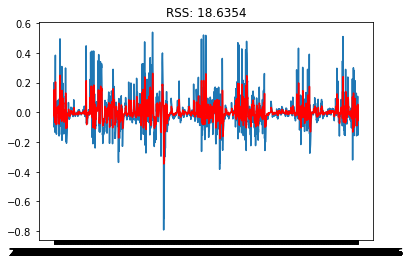

In [327]:
#MA Model
model = ARIMA(dataset_log_scale_minus_moving_average, order=(0,1,4))
results_MA = model.fit()
plt.plot(dataset_log_scale_minus_moving_average)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - dataset_log_scale_minus_moving_average['heartRate'])**2))
print('Plotting MA model')

# ARIMA MODEL

Plotting ARIMA model


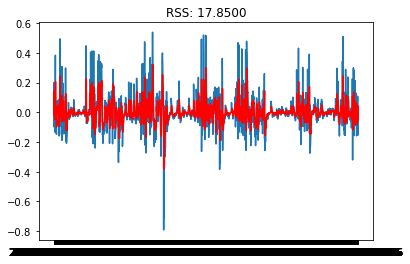

In [375]:
# AR+I+MA = ARIMA model
model = ARIMA(dataset_log_scale_minus_moving_average, order=(8,1,4))
results_ARIMA = model.fit()
plt.plot(dataset_log_scale_minus_moving_average)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - dataset_log_scale_minus_moving_average['heartRate'])**2))
print('Plotting ARIMA model')

# Prediction & Reverse transformations

In [404]:
predictions_AR = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_AR)

date
2022-06-12 09:25     0.000000
2022-06-12 09:28    67.998196
2022-06-12 09:35    67.999100
2022-06-12 09:45    75.221899
2022-06-12 09:55    71.473138
                      ...    
2022-06-19 23:16    71.248021
2022-06-19 23:26    76.458488
2022-06-19 23:36    67.084805
2022-06-19 23:46    69.907217
2022-06-19 23:56    69.612793
Length: 2317, dtype: float64


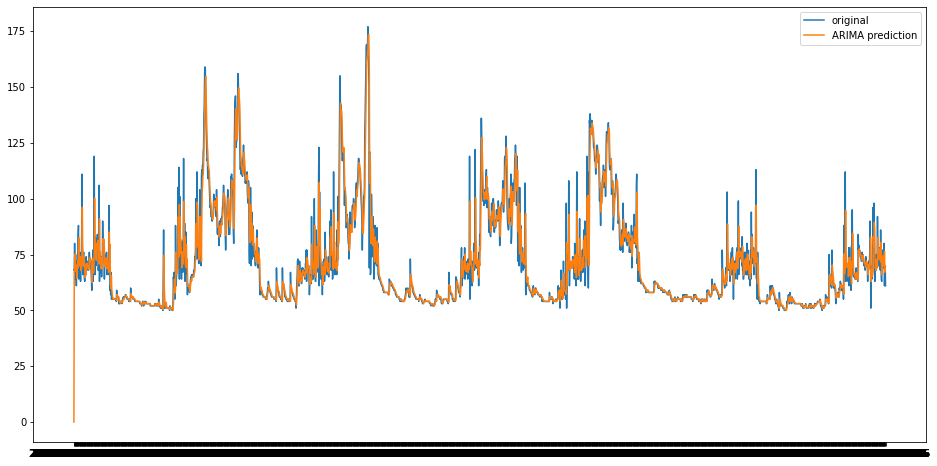

In [405]:
# Inverse of log is exp.
predictions_ARIMA = predictions_ARIMA_log
plt.figure(figsize=(16,8))
plt.plot(indexed_dataset, label="original")
plt.plot(predictions_AR, label="ARIMA prediction")
plt.legend()
plt.show()

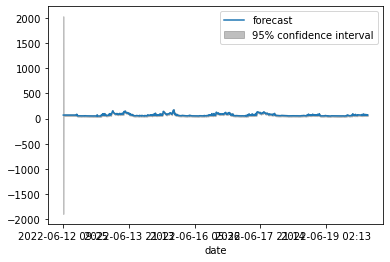

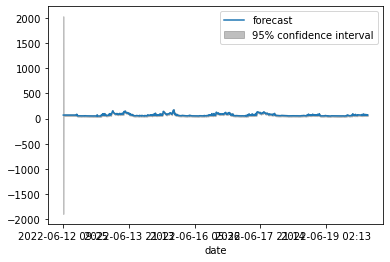

In [426]:
plot_predict(results_AR)

# HeatMap

In [ ]:
heatmap_df = heartrate_df.groupby('date')['heartRate'].apply(list)
max_measures = 0 # max number of measures by day
for i in range (len(heatmap_df.index)):
    if(len(heatmap_df[i]) > max_measures):
        max_measures = len(heatmap_df[i])
for i in range (len(heatmap_df.index)):
    heatmap_df[i] = np.array(heatmap_df[i])
    heatmap_df[i].resize(max_measures) #Resize the array and fill with zeros
matrix_data = []
for i in range (len(heatmap_df.index)):
    matrix_data.append(heatmap_df[i])
matrix_data = np.matrix(matrix_data)

In [ ]:
cmap = sns.cm.rocket_r
dates_range = pd.date_range(starting_date, end_date)
dates_range = np.array(dates_range).reshape(len(dates_range),1)
heat_df = pd.DataFrame(matrix_data, index=dates_range)
sns.heatmap(heat_df, vmin=40, vmax=matrix_data.max() +10, cmap = cmap)
